Columns in the dataset:
Unnamed: 0                       object
ActivePower                     float64
AmbientTemperatue               float64
BearingShaftTemperature         float64
Blade1PitchAngle                float64
Blade2PitchAngle                float64
Blade3PitchAngle                float64
ControlBoxTemperature           float64
GearboxBearingTemperature       float64
GearboxOilTemperature           float64
GeneratorRPM                    float64
GeneratorWinding1Temperature    float64
GeneratorWinding2Temperature    float64
HubTemperature                  float64
MainBoxTemperature              float64
NacellePosition                 float64
ReactivePower                   float64
RotorRPM                        float64
TurbineStatus                   float64
WTG                              object
WindDirection                   float64
WindSpeed                       float64
dtype: object

Missing values:
Unnamed: 0                          0
ActivePower                

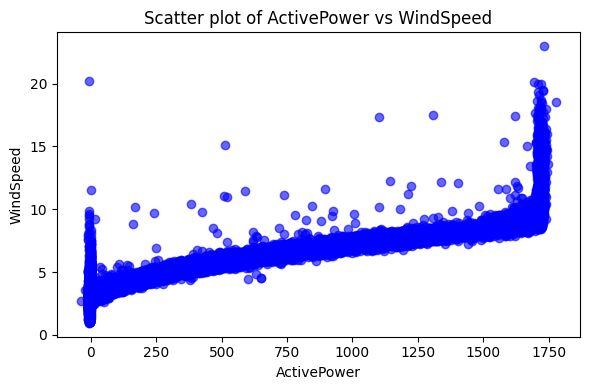

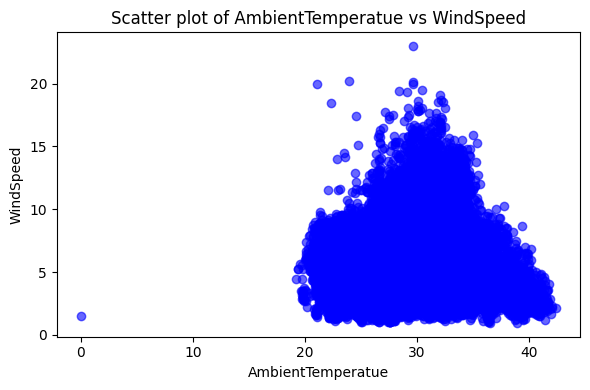

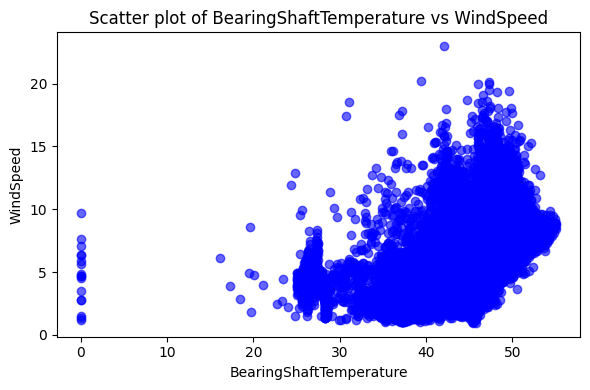

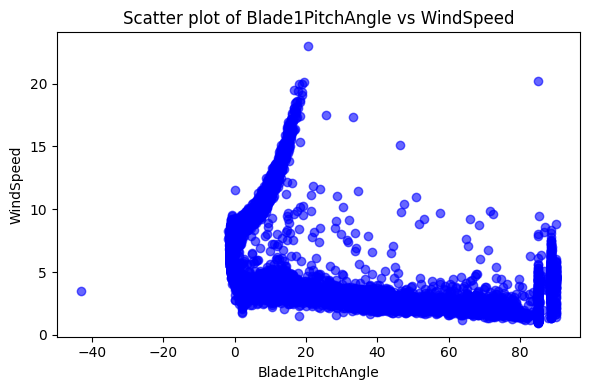

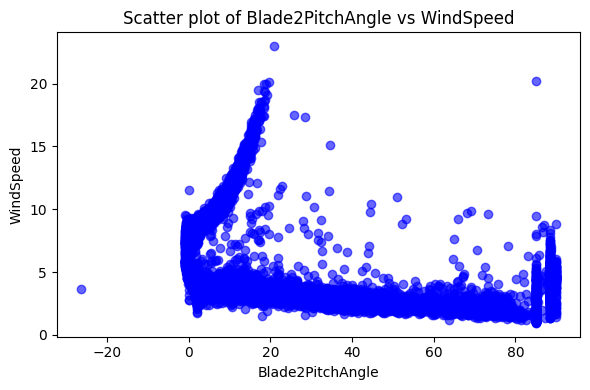

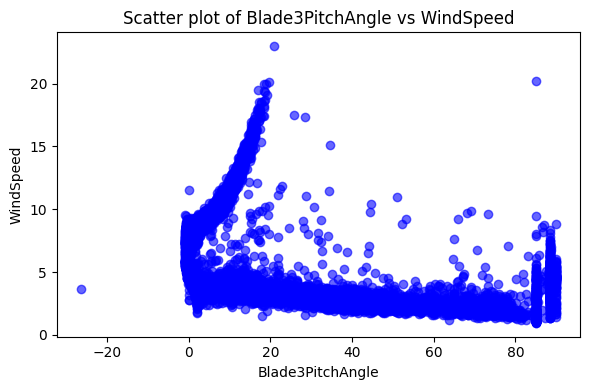

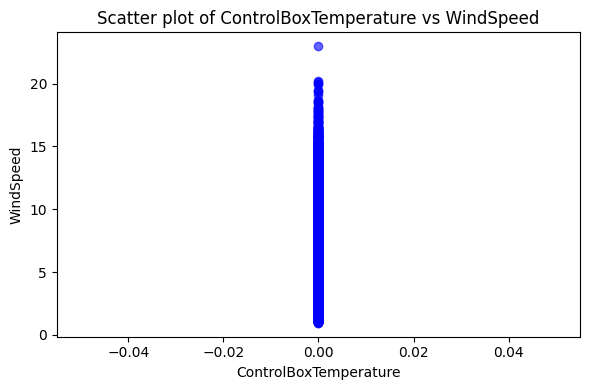

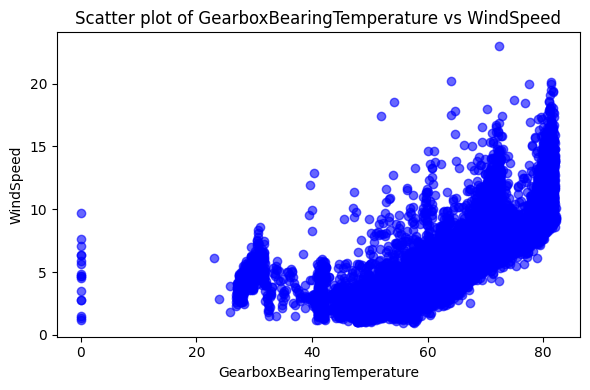

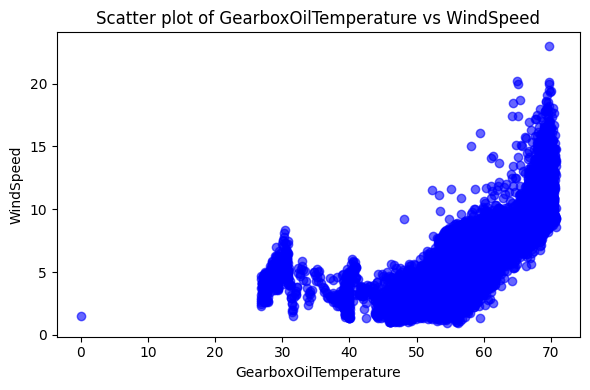

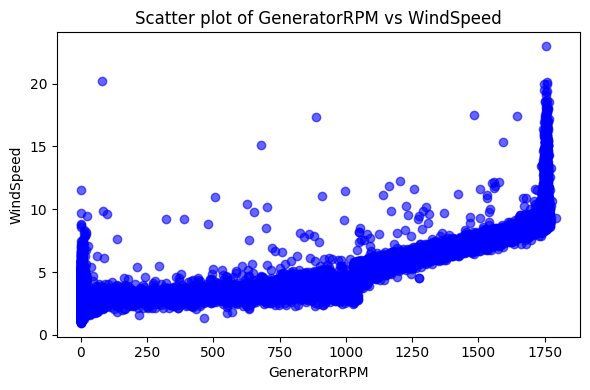

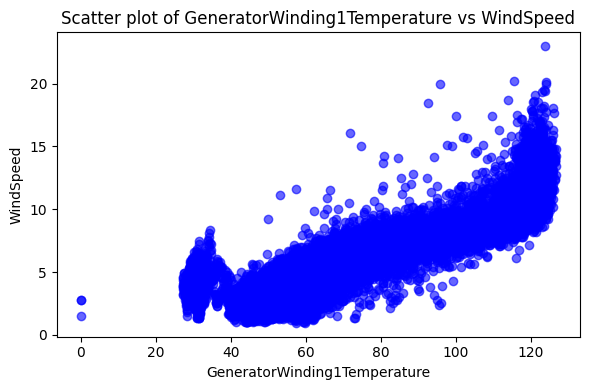

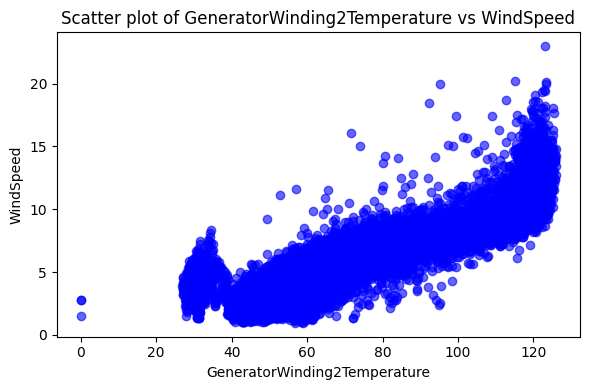

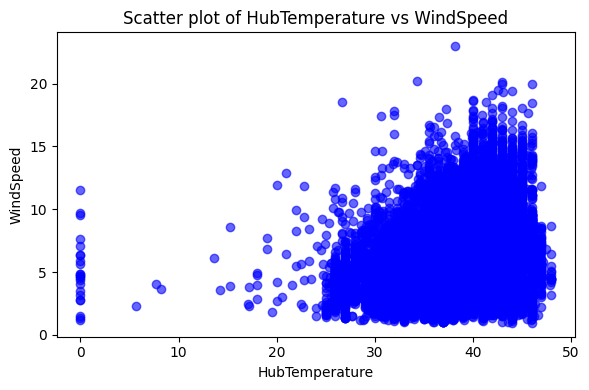

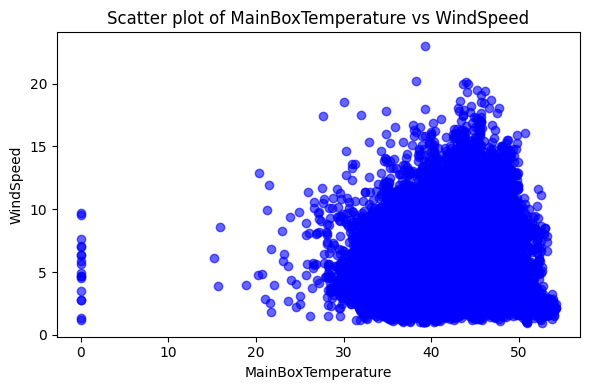

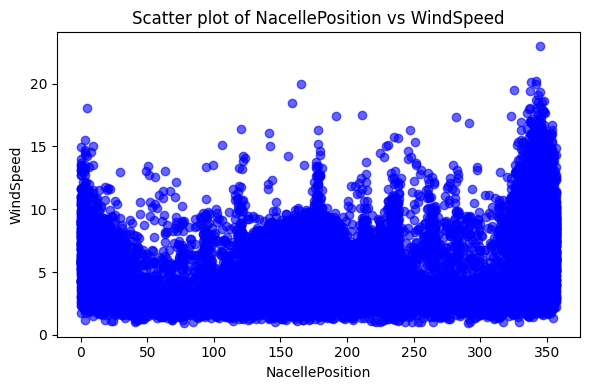

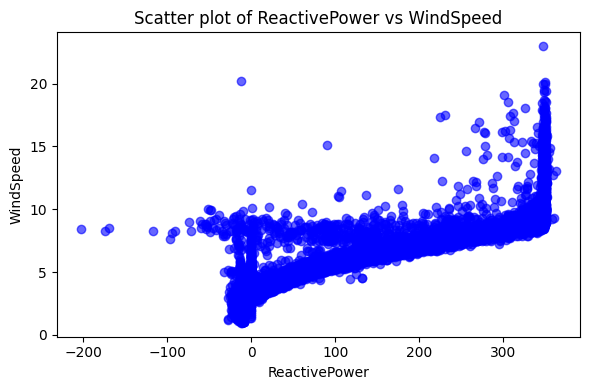

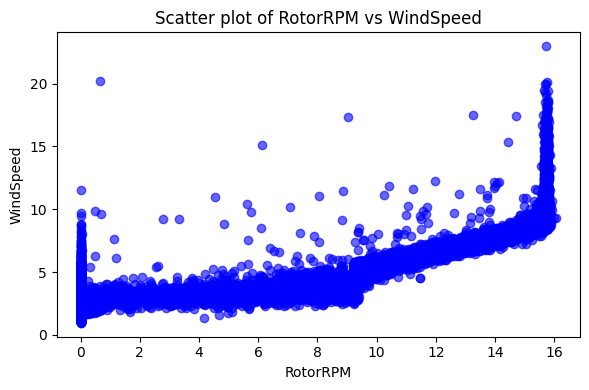

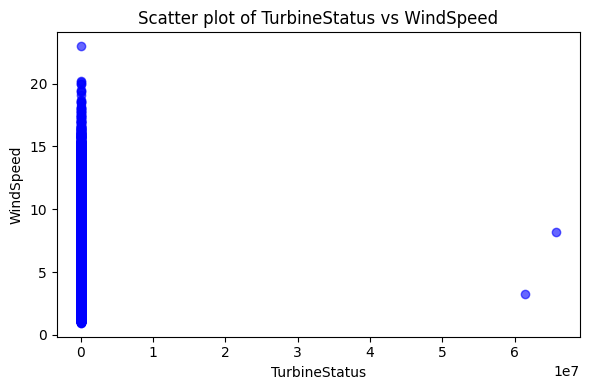

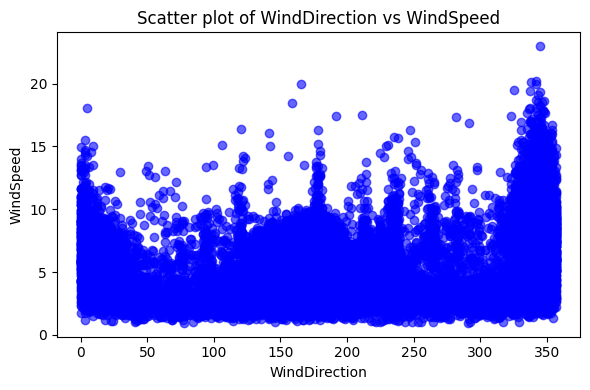


Model Evaluation (XGBoost):
R-squared: 0.9879
MAE: 0.1930
RMSE: 0.2844

True vs Predicted Values:
      True Values  Predicted Values
0        5.785110          5.776728
1        6.343120          5.991564
2        5.982439          5.949219
3        6.768063          6.748992
4        3.994642          3.991402
...           ...               ...
6541     4.548995          4.516737
6542     1.476185          2.432149
6543     5.335465          5.366429
6544     3.965635          4.107841
6545     5.096742          5.001541

[6546 rows x 2 columns]


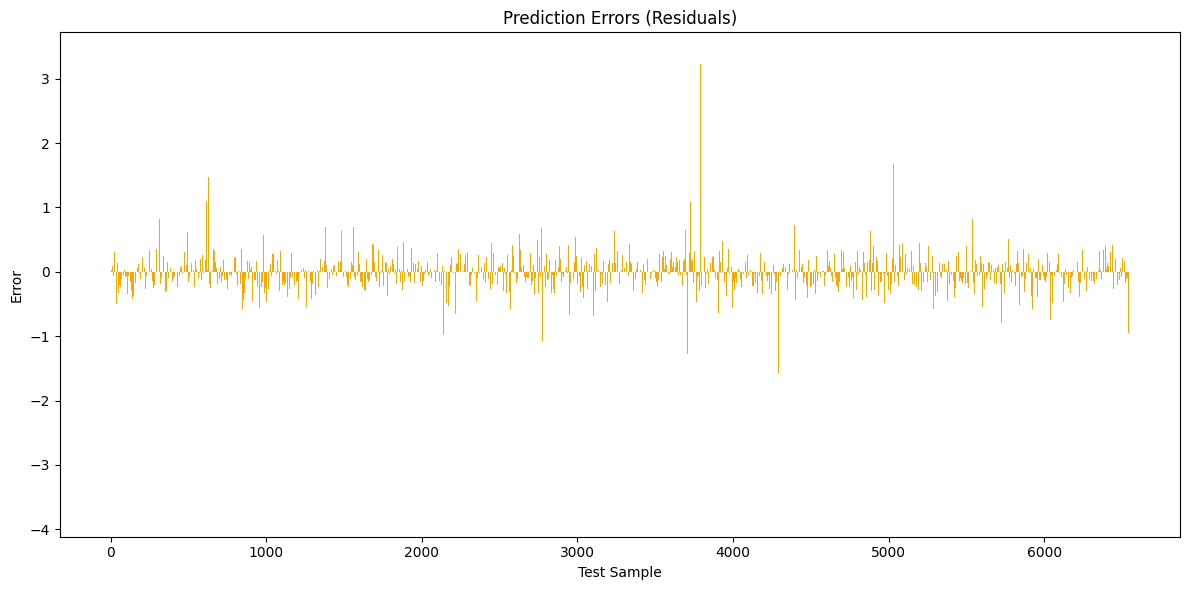

<Figure size 1200x600 with 0 Axes>

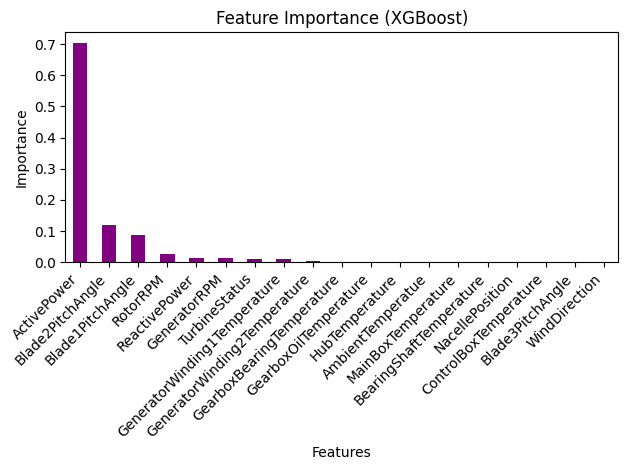

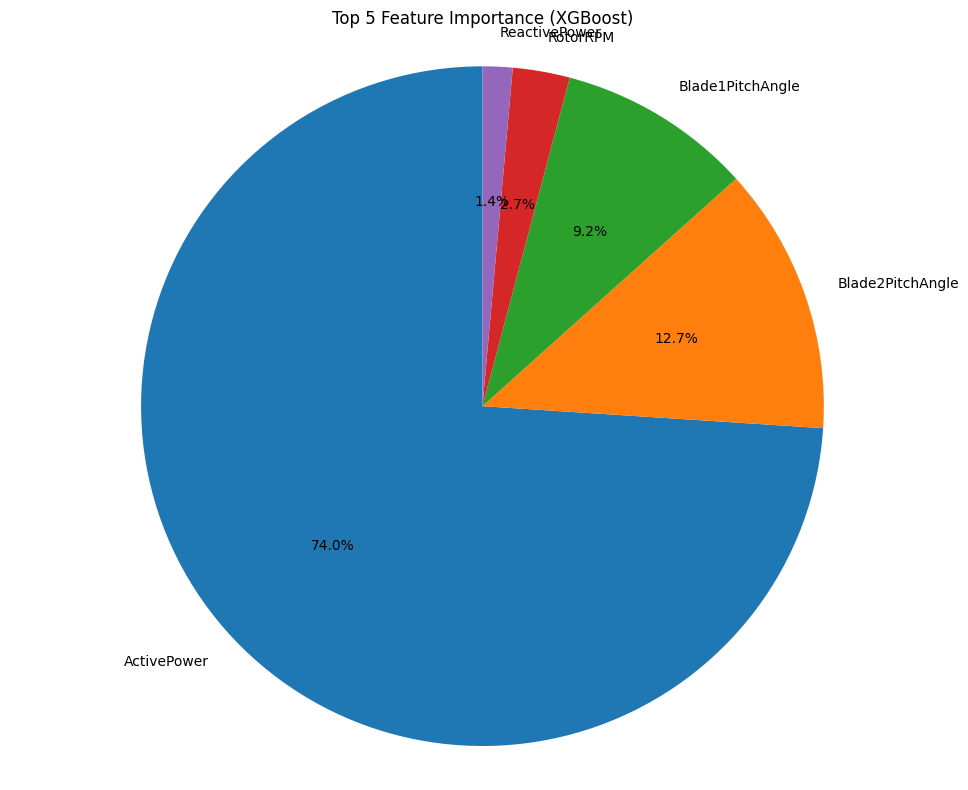

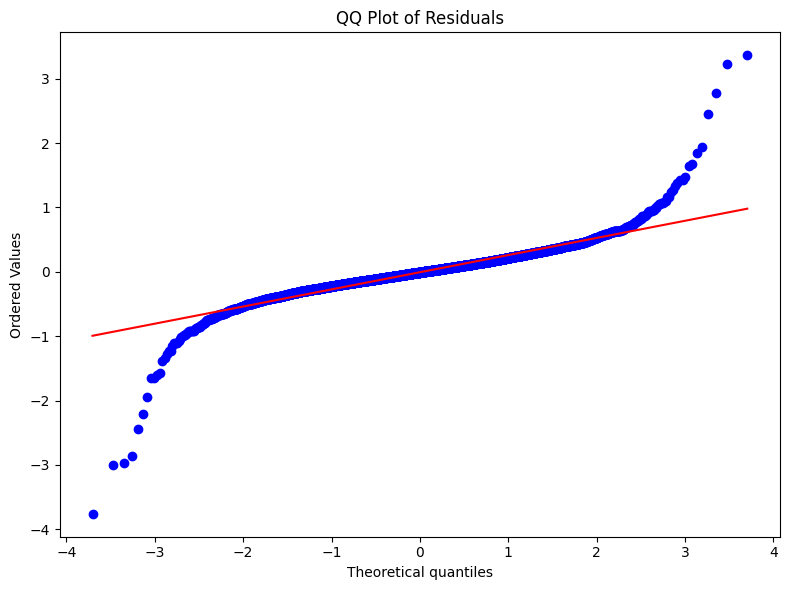

Mean Squared Error (MSE): 0.0809


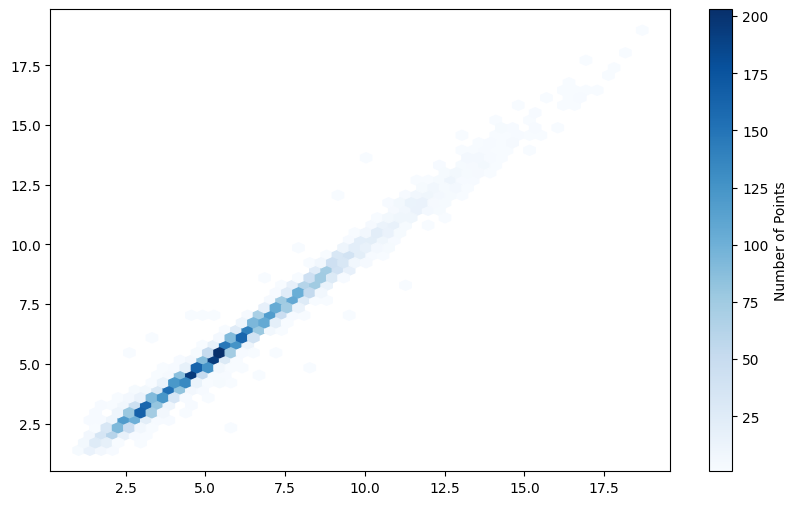

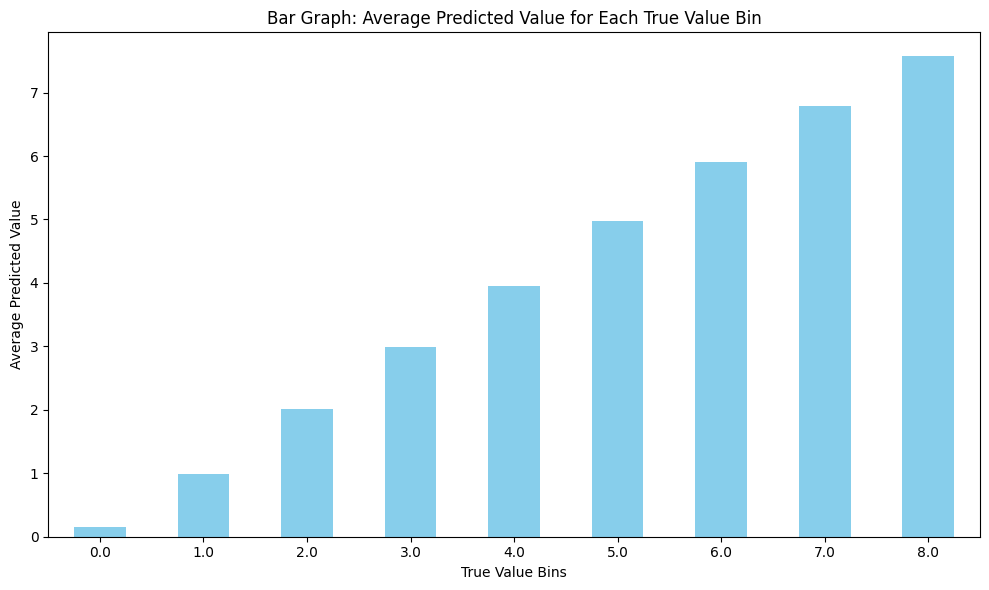

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import probplot

# Data Preparation
df = pd.read_csv('Turbine_Data.csv')

print("Columns in the dataset:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

df = df.dropna()

numeric_columns = df.select_dtypes(include=[np.number]).columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

print("\nNumeric columns:", numeric_columns.tolist())
print("Non-numeric columns:", non_numeric_columns.tolist())

print("\nDataset description (numeric columns only):")
print(df[numeric_columns].describe())

# Assuming the last numeric column is the target variable
target_column = numeric_columns[-1]

# Visualizations

# 1. Scatter plot of each numeric feature against the target variable
for feature in numeric_columns:
    if feature != target_column:
        plt.figure(figsize=(6, 4))
        plt.scatter(df[feature], df[target_column], color='blue', alpha=0.6)
        plt.title(f'Scatter plot of {feature} vs {target_column}')
        plt.xlabel(feature)
        plt.ylabel(target_column)
        plt.tight_layout()
        plt.show()

# Feature Engineering
if 'Date' in df.columns or df[non_numeric_columns[0]].dtype == 'datetime64[ns]':
    date_column = 'Date' if 'Date' in df.columns else non_numeric_columns[0]
    df[date_column] = pd.to_datetime(df[date_column])
    df['Month'] = df[date_column].dt.month
    df['Hour'] = df[date_column].dt.hour

numeric_columns = df.select_dtypes(include=[np.number]).columns

# Prepare features and target
features = [col for col in numeric_columns if col != target_column]
X = df[features]
y = df[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model Training
xgb_model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred = xgb_model.predict(X_test_scaled)

# Model Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Evaluation (XGBoost):")
print(f"R-squared: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Display Predictions
predictions_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred
})

print("\nTrue vs Predicted Values:")
print(predictions_df.reset_index(drop=True))

# Important Plots

# 1. Prediction Errors (residuals)
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.bar(range(len(errors)), errors, color='orange')
plt.title('Prediction Errors (Residuals)')
plt.xlabel('Test Sample')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

# 2. Feature Importance (from XGBoost)
xgb_feature_importance = pd.DataFrame({'feature': features, 'importance': xgb_model.feature_importances_})
xgb_feature_importance = xgb_feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
xgb_feature_importance.plot(x='feature', y='importance', kind='bar', legend=False, color='purple')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Cumulative feature importance pie chart
plt.figure(figsize=(10, 8))
plt.pie(xgb_feature_importance['importance'][:5], labels=xgb_feature_importance['feature'][:5], autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Feature Importance (XGBoost)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 4. QQ Plot of residuals to check normality of errors
plt.figure(figsize=(8, 6))
probplot(errors, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()

# Additional Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Plot of true vs predicted values using a hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(y_test, y_pred, gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Points')

# Group the true and predicted values into bins and calculate the mean predicted value for each bin
bins = np.linspace(min(y_test), max(y_test), 10)  # Create 10 equal-width bins
y_test_binned = pd.cut(y_test, bins, labels=False)
y_pred_binned = pd.cut(y_pred, bins, labels=False)

# Create a DataFrame to store the true and predicted values in their respective bins
binned_df = pd.DataFrame({'True Values': y_test_binned, 'Predicted Values': y_pred_binned})

# Calculate the mean predicted value for each true value bin
bar_data = binned_df.groupby('True Values')['Predicted Values'].mean()

# Plot the bar graph
plt.figure(figsize=(10, 6))
bar_data.plot(kind='bar', color='skyblue')
plt.title('Bar Graph: Average Predicted Value for Each True Value Bin')
plt.xlabel('True Value Bins')
plt.ylabel('Average Predicted Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
